## Visualization practice

- By Qi Sun

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
import folium.plugins

In [8]:
df = pd.read_csv('/Users/yangyang/Downloads/h1b_TRAIN_tableau 2.csv')

df.head()

,Case Id,Case Status,JT_EXECUTIVE_FLAG,Prevailing Wage filter,Longitude,Latitude,SoC_COMPUTER_FLAG,Employer Name,SoC_UPPERCASE_FLAG,JT_PROFESSOR_FLAG,...,Number of Records,Prevailing Wage,JT_SENIOR_FLAG,JT_DATASCIENCE_FLAG,Emp_UNIVERSITY_FLAG,Soc Name,Worksite - Split 1,Worksite - Split 2,COAST_FLAG,Year
0,2817253,CERTIFIED,0,1,74.222116,40.417095,0,YANG'S SEAFOOD LLC,0,0,...,1,52852.8,0,0,0,Accountants,ABERDEEN,NEW JERSEY,"CALIFORNIA, MASSACHUSETTS, NEW JERSEY and 2 more",2011.0
1,2854337,CERTIFIED,0,1,96.829169,32.961790,0,"CRYSTAL TECHNOLOGY & INDUSTRIES, INC.",0,0,...,1,41600.0,0,0,0,Accountants,ADDISON,TEXAS,Other,2011.0
2,2662898,CERTIFIED,0,1,77.046921,38.804835,0,FIRST PAINTING INC.,0,0,...,1,48963.2,0,0,0,Accountants,ALEXANDRIA,VIRGINIA,Other,2011.0
3,2827634,CERTIFIED,0,1,118.127015,34.095287,0,"YANG AND COMPANY CPA, A PROFESSIONAL CORP.",0,0,...,1,41558.4,0,0,0,Accountants,ALHAMBRA,CALIFORNIA,"CALIFORNIA, MASSACHUSETTS, NEW JERSEY and 2 more",2011.0
4,2805991,CERTIFIED,0,1,118.127015,34.095287,0,"YANG AND COMPANY CPA, A PROFESSIONAL CORPORATION",0,0,...,1,41558.4,0,0,0,Accountants,ALHAMBRA,CALIFORNIA,"CALIFORNIA, MASSACHUSETTS, NEW JERSEY and 2 more",2011.0


# Drill down: top 10 employers file the most petitions each year (seaborn)

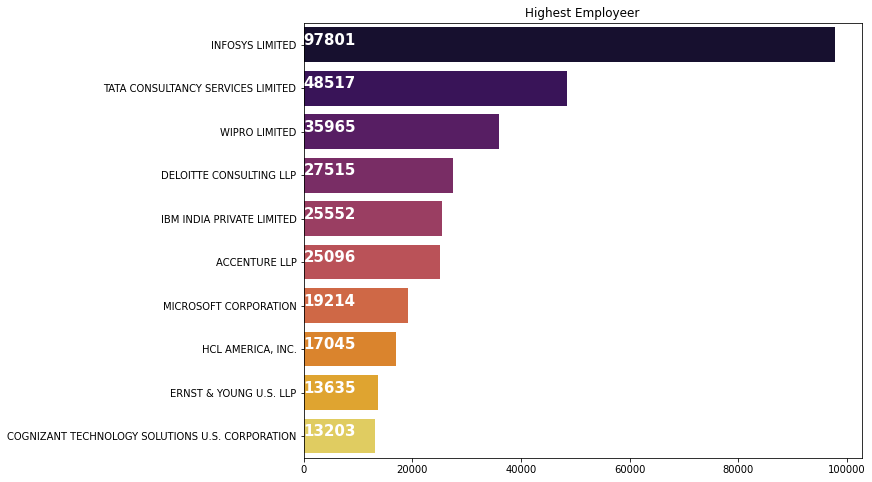

In [9]:
plt.figure(figsize=(10,8))

df02 = df['Employer Name'].value_counts().sort_values(ascending=False)[:10]

ax = sns.barplot(y=df02.index,x=df02.values,palette=sns.color_palette('inferno',10))
for i, v in enumerate(df02.values): 
    ax.text(.5, i, v,fontsize=15,color='white',weight='bold')
    
plt.title('Highest Employeer')
plt.show()

# Contrast: compare applications (status=certified) of data related jobs by year (matplotlib)

In [15]:
df.rename(columns = {'Prevailing Wage':'Prevailing_Wage'}, inplace = True)

data_peeps = df.dropna(subset=['Job Title'])

data_peeps = data_peeps[data_peeps['Job Title'].str.contains('DATA')]
data_scientists = data_peeps[data_peeps['Job Title'].str.contains('DATA SCIENTIST')]
data_analyst = data_peeps[data_peeps['Job Title'].str.contains('DATA ANALYST')]
data_eng = data_peeps[data_peeps['Job Title'].str.contains('DATA ENG')]


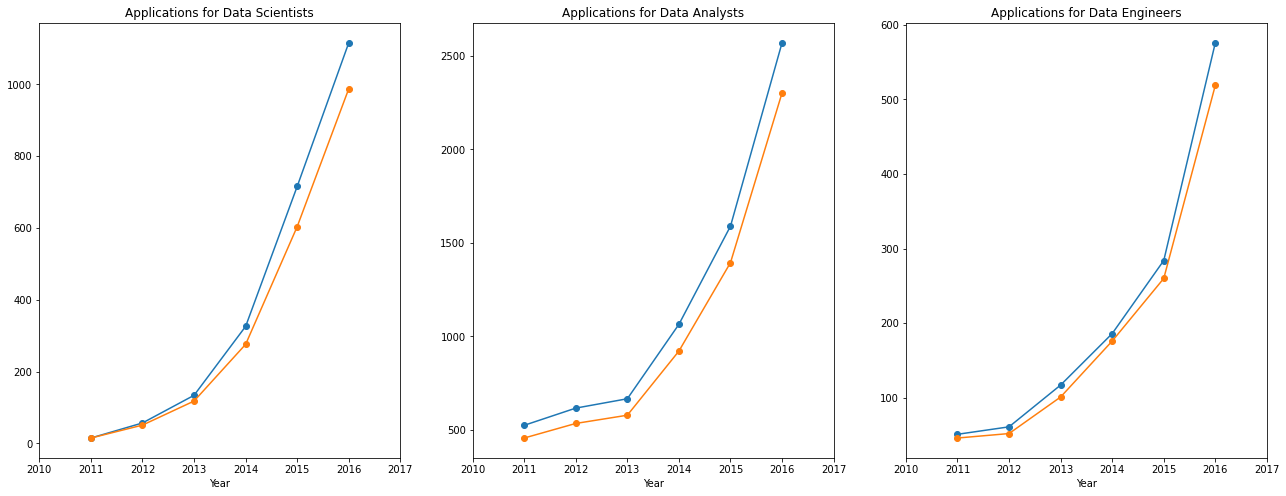

In [16]:
f,ax = plt.subplots(1,3,figsize=(22,8))
# total applications by year
data_scientists.groupby('Year')['Case Status'].count().plot(ax=ax[0],marker='o')
data_analyst.groupby('Year')['Case Status'].count().plot(ax=ax[1],marker='o')
data_eng.groupby('Year')['Case Status'].count().plot(ax=ax[2],marker='o')
# total certified applications by year
data_scientists[data_scientists['Case Status']=='CERTIFIED'].Year.value_counts().plot(marker='o',ax=ax[0])
data_analyst[data_analyst['Case Status']=='CERTIFIED'].Year.value_counts().plot(marker='o',ax=ax[1])
data_eng[data_eng['Case Status']=='CERTIFIED'].Year.value_counts().plot(marker='o',ax=ax[2])

for i,j in zip([0,1,2],['Applications for Data Scientists','Applications for Data Analysts','Applications for Data Engineers']):
    ax[i].set_title(j)
for i in [0,1,2]:
    ax[i].set_xlim([2010,2017])
    
plt.show()

In [19]:
data_scientists.to_csv(r'/Users/yangyang/Desktop/capstone/data_scientists.csv',sep='\t')
data_analyst.to_csv(r'/Users/yangyang/Desktop/capstone/data_analyst.csv',sep='\t')
data_eng.to_csv(r'/Users/yangyang/Desktop/capstone/data_eng.csv',sep='\t')


# Outliers: Salary Distribution of data-related jobs (matplotlib)

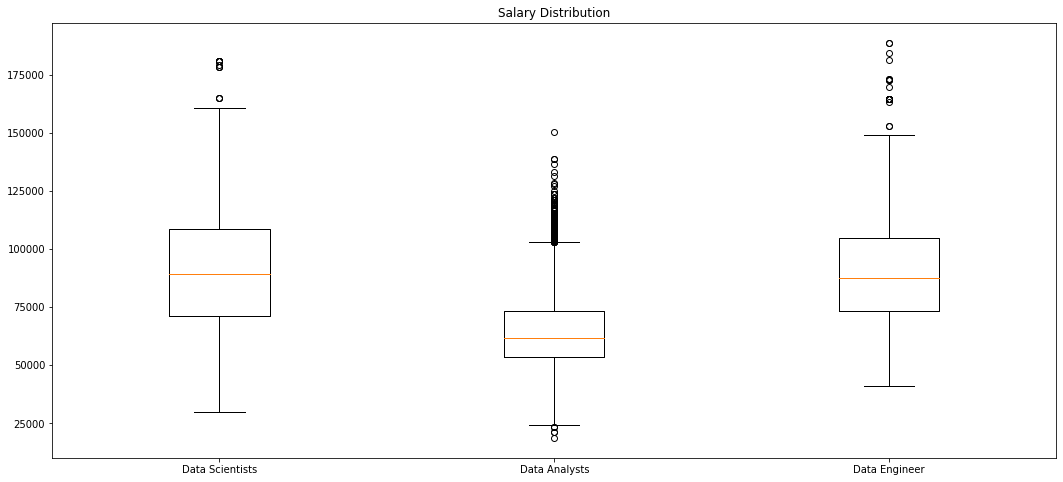

In [19]:
f,ax=plt.subplots(figsize=(18,8))

plt.boxplot([data_scientists[data_scientists['Prevailing_Wage']<200000].Prevailing_Wage,data_analyst[data_analyst['Prevailing_Wage']<200000].Prevailing_Wage,data_eng[data_eng['Prevailing_Wage']<200000].Prevailing_Wage])

ax.set_xticklabels(['Data Scientists','Data Analysts','Data Engineer'])
ax.set_title('Salary Distribution')
plt.show()

# Zoom out: Use Longitude and Latitude to compare data scientist average salary in different states (folium) 

In [9]:
df['Unnamed: 0'] = range(1, len(df) + 1)

In [10]:
# the Longitude in the dataset should be negative 
def Convert(lst): 
    return [ -i for i in lst ] 

In [12]:
df['Longitude02']=Convert(df['Longitude'])

In [17]:
sal_state=data_scientists.groupby(['Latitude','Longitude02','Worksite - Split 2'])['Prevailing_Wage'].median().sort_values(ascending=False).reset_index()

appli=df.groupby(['Latitude','Longitude02'])['Unnamed: 0'].count().reset_index()
locate=sal_state[['Latitude','Longitude02']]
sal=sal_state['Prevailing_Wage']
state=sal_state['Worksite - Split 2']

def color_producer(elevation):
    if elevation < 75000:
        return 'red'
    elif 75000 <= elevation < 100000:
        return 'orange'
    else:
        return 'green'

map1 = folium.Map(location=[39.50, -98.35],tiles='CartoDB dark_matter',zoom_start=3.5)

for point in sal_state.index:
    folium.CircleMarker(list(locate.loc[point]),popup='<b>Average Salary in $: </b>'+str(sal.loc[point])+"<br><b> State: "+str(state.loc[point]),radius=sal.loc[point]*0.0001,color=color_producer(sal.loc[point]),fill_color=color_producer(sal.loc[point]),fill=True).add_to(map1)

map1
